In [85]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import plancklens
from plancklens import utils
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp

In [86]:
cls_path = os.path.join(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

In [172]:
lmax_ivf = 2048
lmin_ivf = 100  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
lmax_qlm = 4096 # We will calculate lensing estimates until multipole lmax_qlm.
nside = 2048 # Healpix resolution of the data and sims.
nlev_t = 30. # Filtering noise level in temperature (here also used for the noise simulations generation).
nlev_p = 55. # 

In [173]:
cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))

In [174]:
transf = hp.gauss_beam(5. / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]

In [175]:
ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / transf) ** 2)
fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
ftl[:lmin_ivf] *= 0.
fel[:lmin_ivf] *= 0.
fbl[:lmin_ivf] *= 0.

In [176]:
#---- N1 lensing bias library:
libdir_n1_dd = '.'
n1_dd = n1.library_n1(libdir_n1_dd,cl_len['tt'],cl_len['te'],cl_len['ee'])

In [177]:
clpp_fid =  utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))['pp']

In [204]:
n1pp_tt = n1_dd.get_n1('ptt', 'p', clpp_fid, ftl, fel, fbl, lmax_ivf-1)
n1pp_eb = n1_dd.get_n1('peb', 'p', clpp_fid, ftl, fel, fbl, lmax_ivf-1)
# n1pp_2 = n1_dd.get_n1('peb', 'p', 2*clpp_fid, ftl, fel, fbl, lmax_ivf-1)

In [189]:
# normalize n1
cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.

In [213]:
qresp_dd = qresp.resp_lib_simple(libdir_n1_dd, lmax_ivf, cl_weight, cl_len,\
                     {'t': ftl, 'e': fel, 'b': fbl}, lmax_qlm)
qc_resp_tt = qresp_dd.get_response('ptt', 'p')**2
qc_resp_eb = qresp_dd.get_response('p_eb', 'p')**2

In [214]:
n1pp_tt_n = utils.cli(qc_resp_tt)[:lmax_ivf]*n1pp_tt
n1pp_eb_n = utils.cli(qc_resp_eb)[:lmax_ivf]*n1pp_eb

In [215]:
Ls = np.arange(0, lmax_ivf)
factor = 1E7*Ls**2*(Ls+1)**2/(2*np.pi)
Lmin = 10

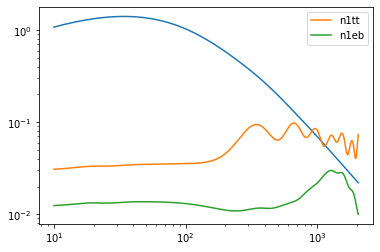

In [216]:
plt.plot(Ls[Lmin:lmax_ivf], (factor*clpp_fid[:lmax_ivf])[Lmin:lmax_ivf])
plt.plot(Ls[Lmin:lmax_ivf], (factor*n1pp_tt_n)[Lmin:lmax_ivf], label='n1tt')
plt.plot(Ls[Lmin:lmax_ivf], (factor*n1pp_eb_n)[Lmin:lmax_ivf], label='n1eb')
plt.xscale('log')
plt.yscale('log')
plt.legend()